In [10]:
# import necessary libraries

import pandas as pd
import numpy as np
import os
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl

In [11]:
# Convert status column's catigrical values from MV to PT (Productive Time) and from QMV to NPT(Non Productive Time)
df_ops_code=pd.read_excel(r"/Users/vagifaliyev/Desktop/KPI Project/DDRs/DDR_01.08.2023.xlsx", sheet_name="Əməliyyatların Kodu", usecols=["Kod","Vaxt.1"])
df_ops_code=df_ops_code.rename(columns={"Kod":"Ops Code","Vaxt.1":"Status"})
df_ops_code['Status'].replace({"MV":"PT", "QMV":"NPT"}, inplace=True)
pd.set_option('display.max_columns', None)
df_ops=df_ops_code
df_ops.drop('Status', axis=1, inplace=True)
df_ops.set_index('Ops Code', inplace=True)

In [12]:
# Read the folders to observe inside
files=os.listdir(r"/Users/vagifaliyev/Desktop/KPI Project/DDRs/")

In [22]:
#Create empty lists for later use:
ddr_list=[]
time_list=[]
all_ops=[]

day_list=[]
daily_drill=[]
TD=[]

# Set a loop for combining individual excel files to single KPI excel file.
for file in sorted(files):
    df1=pd.read_excel(r"/Users/vagifaliyev/Desktop/KPI Project/DDRs/"+file)
    day=df1['Unnamed: 4'].iloc[4].strftime("%d %B %Y")
    d_drill=df1['Unnamed: 3'][8]-df1['Unnamed: 3'][7]
    td=df1['Unnamed: 3'][8]
    day_list.append(day)
    daily_drill.append(d_drill)
    TD.append(td)
    
    df=pd.read_excel(r"/Users/vagifaliyev/Desktop/KPI Project/DDRs/"+file,
                     sheet_name="GM-DDR",skiprows=47,usecols=[1,2,3,5,7,8])
    df=df.dropna(axis=0,how='any')
    df.rename(columns={
        "Unnamed: 2": "End",
        "Vaxt": "Start",
        "Əməliyyat kodu":"Ops Code",
        "Unnamed: 7": "Status",
        "Saat": "Time",
        "Gündəlik məlumat":"Daily Operations"
    }, inplace=True)
    
    # Create daily activity column which joins operation in every excel file
    joined_description=""
    daily_ops=[]
    for description in df["Daily Operations"]:
        joined_description+='.'+description
    daily_ops.append(joined_description)
    df_daily_ops=pd.DataFrame(daily_ops)
    all_ops.append(df_daily_ops) 
    
#     Create dataframe of operation times for every operation code for each day
    daily_grouped_hours=df.groupby(by="Ops Code")["Time"].sum()
    df_grouped_hours=pd.DataFrame(daily_grouped_hours).T
#     df_grouped_hours=df_grouped_hours.merge(df_ops_code, on="Ops Code", how='left').T
    time_list.append(df_grouped_hours)
 
#     Create Dataframe of operations    
df_all_ops=pd.concat(all_ops, axis=0,ignore_index=True)

# Create Dataframe of time for each operation code for each day
df_all_time=pd.concat(time_list, axis=0,ignore_index=True).fillna(0)
merged=pd.merge(df_ops, df_all_time.T, left_index=True, right_index=True, how='left').fillna(0).T


# Combine time and operation dataframes and export final KPI file.
df_info=pd.DataFrame({'Days':day_list, 'Depth':TD, 'Daily drill':daily_drill})
df_final=pd.concat([df_info, df_all_ops, merged], axis=1).rename(columns={0:"Operation's Description"})
df_final.to_excel(r"/Users/vagifaliyev/Desktop/Qalmaz_657_KPI.xlsx", sheet_name="Operations")


/Users/vagifaliyev/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/vagifaliyev/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/vagifaliyev/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/vagifaliyev/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/vagifaliyev/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx

Text(0, 0.5, 'Hour')

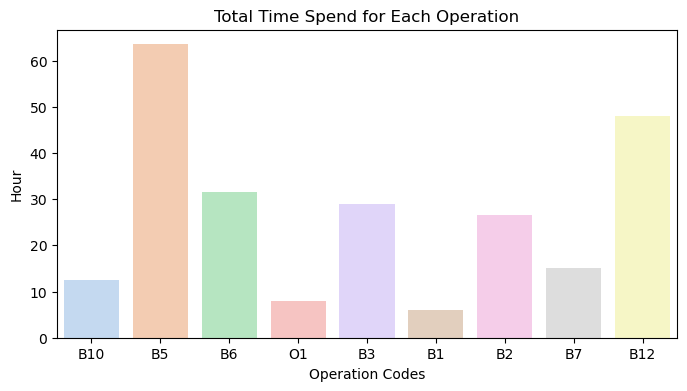

In [14]:
plt.figure(figsize=(8,4))
fig=sns.barplot(x=df_all_time.keys(), y=[df_all_time[i].sum().round(2) for i in df_all_time], 
                palette="pastel", alpha=0.7)
fig.set_title("Total Time Spend for Each Operation")
fig.set_xlabel("Operation Codes")
fig.set_ylabel("Hour")